<a href="https://colab.research.google.com/github/erfunmirzaei/DOL-Project1/blob/main/Project1_DOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition  


In this project, we implemented federated learning algorithms as samples of the decentralized optimization algorithms for the case when client datasets are i.i.d. or non-iid. Then, compare the results with the centralized version.

For this purpose, a convolution neural network and the cifar10 dataset are used. In the first part, we trained the network in a centralized manner, as in the standard cases in deep learning. We implemented the FedAvg algorithm, one of the most famous algorithms in federated learning, when the client datasets are iid. In the following, the iid assumption was discarded. Thus, we split datasets in a non-iid manner. Therefore for non-iid datasets, we implemented the FedProx algorithm and compared the results to the FedAvg Algorithm.

In [ ]:
#Importing required libraries 
import numpy as np
import matplotlib.pyplot as plt
import math 
import os, sys 
import random 
import copy
import string

import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from typing import Callable, List, Optional, Tuple
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence 
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torch.optim as optim

from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

## Networks

In [ ]:
class Deep_CNN(nn.Module):
    """
    Implement the network architecture which was used in "Personalized Federated Learning: A Meta-Learning Approach" Paper.
    """
    def __init__(self, num_classes):
        super(Deep_CNN, self).__init__() 

        # First layer
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)

        # First Hidden layer 
        self.fc1 = nn.Linear(16 * 5 *5, 120)
        
        # Second Hidden layer
        self.fc2 = nn.Linear(120, 84)
        
        # Classifier 
        self.fc3 = nn.Linear(84,num_classes)

        # Activation Function 
        self.relu = nn.ReLU()     

        # Dropout 
        self.dropout = nn.Dropout( p= 0.2)
           
    
    def forward(self,x):
        # First Layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Second Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, start_dim = 1)

        # First Hidden layer 
        x = self.fc1(x)
        x = self.relu(x)

        # Second Hidden layer
        x = self.fc2(x)
        x = self.relu(x)
   
        # Classifier
        x = self.fc3(x)

        return x


In [ ]:
class PerFed_MAML_Network(nn.Module):
    """
    Implement the network architecture which was used in "Personalized Federated Learning: A Meta-Learning Approach" Paper.
    """
    def __init__(self, input_dim, num_classes):
        super(PerFed_MAML_Network, self).__init__()
        
        self.input_dim = input_dim

        # First Hidden layer 
        self.fc1 = nn.Linear(input_dim, 80)

        # Second Hidden layer
        self.fc2 = nn.Linear(80, 60)
        
        # Classifier 
        self.fc3 = nn.Linear(60,num_classes)

        # Activation Function 
        self.elu = nn.ELU()        

        # Dropout
        self.dropout = nn.Dropout(p = 0.3)

    def forward(self,x):
        # 
        x = torch.flatten(x, start_dim = 1)

        # First Hidden layer 
        x = self.fc1(x)
        x = self.elu(x)
        #x = self.dropout(x)

        # Second Hidden layer
        x = self.fc2(x)
        x = self.elu(x)
        #x = self.dropout(x)

        # Classifier 
        x = self.fc3(x)

        return x

# Centralized

## Preprocessing 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)
max_epochs = 1000
batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


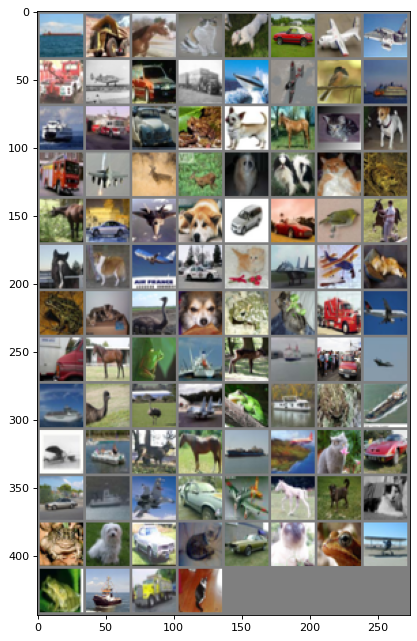

 ship truck horse   cat   dog   car plane plane truck plane   car truck  ship plane  bird  ship  ship truck   car  frog   dog horse   cat   dog truck plane  deer  deer   dog   dog   cat  frog horse   car plane   dog   car   car  bird horse horse   dog plane   car   cat plane plane   cat  frog   cat  bird   dog  frog   cat truck plane truck horse  frog  ship  deer  ship   car plane  ship  bird  bird plane  frog  ship  frog  ship plane  ship  deer horse  ship plane   cat   car   car  ship plane   car plane horse   dog   cat  frog   dog   car   cat   car   cat  frog plane  frog  ship truck   cat


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 10), dpi=80)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Sanity Check 
(try to overfit on a mini batch)

In [ ]:
# Model 
Net = Deep_CNN(10)
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.01, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses = []
train_accs = []

validation_losses = []
val_accs = []

dataiter = iter(trainloader)
train_data, train_labels = dataiter.next()

val_dataiter = iter(testloader)
val_data, val_labels = val_dataiter.next()

max_epochs = 1000

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    # Transfer to GPU
    train_data, train_labels = train_data.to(device), train_labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = Net(train_data)

    loss = criterion(batch_train_outputs, train_labels.long())
    loss.backward()
    optimizer.step()
    # scheduler.step()
    # print statistics
    running_trainloss += loss.item()
    running_loss += loss.item()

    train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

    if train_cnt % 100 == 99:    # print every 10 mini-batches
        print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 10))
        running_loss = 0.0
    
    train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        #for val_data, val_labels in tqdm(validation_generator):
        # Transfer to GPU
        val_data, val_labels = val_data.to(device), val_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(val_data)
        
        val_loss = criterion(batch_outputs, val_labels.long())

        running_valloss += val_loss.item()
        running_loss += val_loss.item()

        val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

        if val_cnt % 10 == 9:    # print every 10 mini-batches
            print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 10))
            running_loss = 0.0

        val_cnt += 1
            
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/1000 [00:00<?, ?it/s]

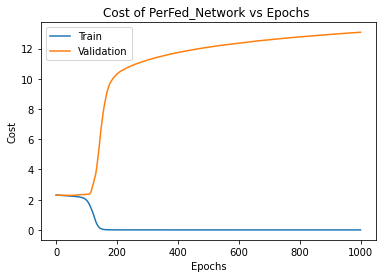

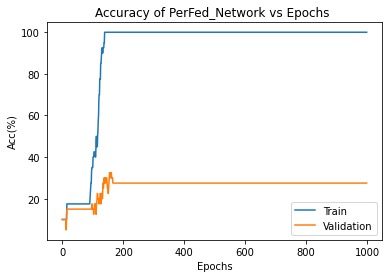

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of PerFed_Network vs Epochs ")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of PerFed_Network vs Epochs ")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

## Centeralized Training 

In [ ]:
# Model 
Net = Deep_CNN(10)
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr = 0.05, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

max_epochs = 10

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for train_data, train_labels in tqdm(trainloader):
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Net(train_data)
        # print(batch_train_outputs.shape, train_labels.shape)
        # break
        loss = criterion(batch_train_outputs, train_labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0

        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in tqdm(testloader):
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net(val_data)
            
            val_loss = criterion(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1
    
    # scheduler.step()      
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    validation_losses.append(running_valloss / val_cnt)
    val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 1 : 1.784337
Cost of Train data after 200 iterations in epoch 1 : 1.530865
Cost of Train data after 300 iterations in epoch 1 : 1.444398
Cost of Train data after 400 iterations in epoch 1 : 1.381743
Cost of Train data after 500 iterations in epoch 1 : 1.324152


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 1 : 1.286862


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 2 : 1.253100
Cost of Train data after 200 iterations in epoch 2 : 1.219277
Cost of Train data after 300 iterations in epoch 2 : 1.188871
Cost of Train data after 400 iterations in epoch 2 : 1.184487
Cost of Train data after 500 iterations in epoch 2 : 1.165312


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 2 : 1.164084


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 3 : 1.087641
Cost of Train data after 200 iterations in epoch 3 : 1.086872
Cost of Train data after 300 iterations in epoch 3 : 1.092257
Cost of Train data after 400 iterations in epoch 3 : 1.048413
Cost of Train data after 500 iterations in epoch 3 : 1.046287


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 3 : 1.098518


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 4 : 0.980040
Cost of Train data after 200 iterations in epoch 4 : 0.992922
Cost of Train data after 300 iterations in epoch 4 : 1.001723
Cost of Train data after 400 iterations in epoch 4 : 0.992563
Cost of Train data after 500 iterations in epoch 4 : 0.974087


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 4 : 1.039629


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 5 : 0.923037
Cost of Train data after 200 iterations in epoch 5 : 0.915290
Cost of Train data after 300 iterations in epoch 5 : 0.915263
Cost of Train data after 400 iterations in epoch 5 : 0.943148
Cost of Train data after 500 iterations in epoch 5 : 0.909057


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 5 : 1.028828


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 6 : 0.852232
Cost of Train data after 200 iterations in epoch 6 : 0.861149
Cost of Train data after 300 iterations in epoch 6 : 0.864120
Cost of Train data after 400 iterations in epoch 6 : 0.865686
Cost of Train data after 500 iterations in epoch 6 : 0.877223


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 6 : 1.025669


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 7 : 0.791173
Cost of Train data after 200 iterations in epoch 7 : 0.800505
Cost of Train data after 300 iterations in epoch 7 : 0.838580
Cost of Train data after 400 iterations in epoch 7 : 0.833762
Cost of Train data after 500 iterations in epoch 7 : 0.843545


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 7 : 1.001424


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 8 : 0.758973
Cost of Train data after 200 iterations in epoch 8 : 0.764527
Cost of Train data after 300 iterations in epoch 8 : 0.798982
Cost of Train data after 400 iterations in epoch 8 : 0.775411
Cost of Train data after 500 iterations in epoch 8 : 0.810365


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 8 : 1.020339


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 9 : 0.708908
Cost of Train data after 200 iterations in epoch 9 : 0.734568
Cost of Train data after 300 iterations in epoch 9 : 0.754548
Cost of Train data after 400 iterations in epoch 9 : 0.782905
Cost of Train data after 500 iterations in epoch 9 : 0.773108


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 9 : 1.009843


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 10 : 0.664773
Cost of Train data after 200 iterations in epoch 10 : 0.717310
Cost of Train data after 300 iterations in epoch 10 : 0.738368
Cost of Train data after 400 iterations in epoch 10 : 0.741664
Cost of Train data after 500 iterations in epoch 10 : 0.751377


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 10 : 1.006574


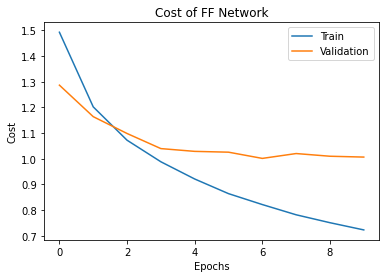

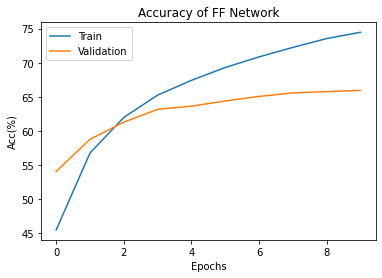

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.title("Cost of FF Network")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title("Accuracy of FF Network")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
# Model 
Net2 = Deep_CNN(10)
Net2.to(device)

# Define Loss function and Optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(Net2.parameters(), lr = 0.01, momentum = 0.9)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses2 = []
validation_losses2 = []

train_accs2 = []
val_accs2 = []

max_epochs = 10

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for train_data, train_labels in tqdm(trainloader):
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)
        
        # zero the parameter gradients
        optimizer2.zero_grad()

        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Net2(train_data)

        loss = criterion2(batch_train_outputs, train_labels)
        loss.backward()
        optimizer2.step()
        
        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0

        train_cnt += 1
    
    # Validation
    running_loss, val_acc = 0.0, 0.0

    with torch.set_grad_enabled(False):
        for val_data, val_labels in tqdm(testloader):
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net2(val_data)
            
            val_loss = criterion2(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()
            running_loss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            if val_cnt % 100 == 99:    # print every 10 mini-batches
                print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
                running_loss = 0.0

            val_cnt += 1
    
    # scheduler.step()      
    train_losses2.append(running_trainloss / train_cnt)
    train_accs2.append(train_acc / train_cnt * 100)
    validation_losses2.append(running_valloss / val_cnt)
    val_accs2.append(val_acc / val_cnt * 100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 1 : 1.813383
Cost of Train data after 200 iterations in epoch 1 : 1.564270
Cost of Train data after 300 iterations in epoch 1 : 1.449493
Cost of Train data after 400 iterations in epoch 1 : 1.380111
Cost of Train data after 500 iterations in epoch 1 : 1.324100


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 1 : 1.315552


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 2 : 1.270802
Cost of Train data after 200 iterations in epoch 2 : 1.245755
Cost of Train data after 300 iterations in epoch 2 : 1.224694
Cost of Train data after 400 iterations in epoch 2 : 1.205784
Cost of Train data after 500 iterations in epoch 2 : 1.161293


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 2 : 1.200448


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 3 : 1.091955
Cost of Train data after 200 iterations in epoch 3 : 1.134846
Cost of Train data after 300 iterations in epoch 3 : 1.116417
Cost of Train data after 400 iterations in epoch 3 : 1.103558
Cost of Train data after 500 iterations in epoch 3 : 1.085386


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 3 : 1.123963


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 4 : 1.032194
Cost of Train data after 200 iterations in epoch 4 : 1.037082
Cost of Train data after 300 iterations in epoch 4 : 1.024128
Cost of Train data after 400 iterations in epoch 4 : 1.021655
Cost of Train data after 500 iterations in epoch 4 : 1.040407


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 4 : 1.094192


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 5 : 0.944992
Cost of Train data after 200 iterations in epoch 5 : 0.967731
Cost of Train data after 300 iterations in epoch 5 : 0.987039
Cost of Train data after 400 iterations in epoch 5 : 0.980239
Cost of Train data after 500 iterations in epoch 5 : 0.977033


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 5 : 1.074626


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 6 : 0.892694
Cost of Train data after 200 iterations in epoch 6 : 0.929424
Cost of Train data after 300 iterations in epoch 6 : 0.921632
Cost of Train data after 400 iterations in epoch 6 : 0.951796
Cost of Train data after 500 iterations in epoch 6 : 0.902369


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 6 : 1.105788


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 7 : 0.835673
Cost of Train data after 200 iterations in epoch 7 : 0.864735
Cost of Train data after 300 iterations in epoch 7 : 0.862947
Cost of Train data after 400 iterations in epoch 7 : 0.901751
Cost of Train data after 500 iterations in epoch 7 : 0.896279


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 7 : 1.060123


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 8 : 0.819295
Cost of Train data after 200 iterations in epoch 8 : 0.832790
Cost of Train data after 300 iterations in epoch 8 : 0.822532
Cost of Train data after 400 iterations in epoch 8 : 0.840675
Cost of Train data after 500 iterations in epoch 8 : 0.864578


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 8 : 1.054483


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 9 : 0.787864
Cost of Train data after 200 iterations in epoch 9 : 0.790940
Cost of Train data after 300 iterations in epoch 9 : 0.816288
Cost of Train data after 400 iterations in epoch 9 : 0.821228
Cost of Train data after 500 iterations in epoch 9 : 0.818093


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 9 : 1.042923


  0%|          | 0/500 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 10 : 0.723712
Cost of Train data after 200 iterations in epoch 10 : 0.766861
Cost of Train data after 300 iterations in epoch 10 : 0.779026
Cost of Train data after 400 iterations in epoch 10 : 0.785218
Cost of Train data after 500 iterations in epoch 10 : 0.797478


  0%|          | 0/100 [00:00<?, ?it/s]

Cost of Validation data after 100 iterations in epoch 10 : 1.046911


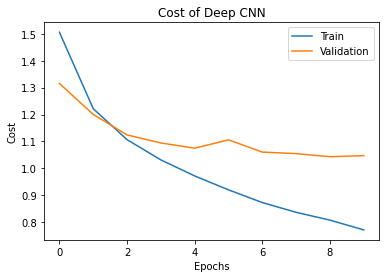

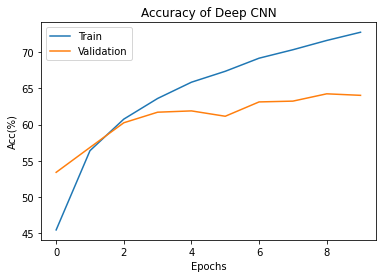

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    plt.plot(train_losses2)
    plt.plot(validation_losses2)
    plt.title("Cost of Deep CNN")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    plt.plot(train_accs2)
    plt.plot(val_accs2)
    plt.title("Accuracy of Deep CNN")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train","Validation"])
    plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/PerFed_Net.pth'
torch.save(Net.state_dict(), PATH)

# Federated Learning (IID) 

## Split Client's datasets

In [ ]:
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)

batch_size2 = 50

trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform2)

testset2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform2)

testloader2 = torch.utils.data.DataLoader(testset2, batch_size=batch_size2,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

n = 100
N = len(trainset2.__dict__['targets'])
N_prime = len(testset2.__dict__['targets']) 
n_i = N // n
n_i_prime = N_prime // n

train_sets2 = []
test_sets2 = []
for i in range(n):
    subset1, trainset2 = random_split(trainset2, (n_i ,N - n_i))
    train_sets2.append(subset1)
    N = N - n_i 

    subset2, testset2 = random_split(testset2, (n_i_prime ,N_prime - n_i_prime))
    test_sets2.append(subset2)
    N_prime = N_prime - n_i_prime 

train_loaders2 = [torch.utils.data.DataLoader(train_sets2[i], batch_size=batch_size2,
                                          shuffle=True, num_workers=2) for i in range(n)] 


test_loaders2 = [torch.utils.data.DataLoader(test_sets2[i], batch_size=batch_size2,
                                          shuffle=True, num_workers=2) for i in range(n)]

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
labels = []
for train_data, train_labels in train_loaders2[9]:
    labels.append(train_labels)

In [ ]:
x = 0
for i in labels:
    for j in i:
        if j == 2:
            x += 1

print(x)

43


## Primal (FedAvg)

In [ ]:
class FedAvg_ClientUpdate(object):
    
    def __init__(self, train_loader):

        self.train_loader =  train_loader
        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def update(self, net, max_epochs, lr):   
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)           
        
        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):
            
            running_trainloss, train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.criterion(batch_train_outputs, train_labels)
                loss.backward()
                optimizer.step()
                
                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1
           
            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs) / len(train_accs) 

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict

## FedAvg Training 

In [ ]:
# Model 
Net3 = Deep_CNN(10)
Net3.to(device)

# # Define Loss function and Optimizer
criterion3 = nn.CrossEntropyLoss()

train_losses3 = []
validation_losses3 = []

train_accs3 = []
val_accs3 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.01
w_dict = copy.deepcopy(Net3.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders2[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net3).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net3.load_state_dict(w_dict)
    # print("******", Net3.state_dict()['fc1.bias'])

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader2:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net3(val_data)
            
            val_loss = criterion3(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    train_losses3.append(running_trainloss / train_cnt)
    train_accs3.append(train_acc / train_cnt * 100)
    validation_losses3.append(running_valloss / val_cnt)
    val_accs3.append(val_acc / val_cnt * 100)

  0%|          | 0/50 [00:00<?, ?it/s]

Cost of Train data for client 93 in round 1 for 5 epochs: 1.768010
Cost of Train data for client 79 in round 1 for 5 epochs: 1.772693
Cost of Train data for client 7 in round 1 for 5 epochs: 1.799394
Cost of Train data for client 76 in round 1 for 5 epochs: 1.806033
Cost of Train data for client 60 in round 1 for 5 epochs: 1.775043
Cost of Train data for client 52 in round 1 for 5 epochs: 1.829702
Cost of Train data for client 89 in round 1 for 5 epochs: 1.720809
Cost of Train data for client 33 in round 1 for 5 epochs: 1.804798
Cost of Train data for client 31 in round 1 for 5 epochs: 1.755063
Cost of Train data for client 61 in round 1 for 5 epochs: 1.795969
----------
Cost of Train data for in round 1: 1.782751
Cost of Validation data for in round 1: 1.827803
Acc of Train data for in round 1: 39.472000
Acc of Validation data for in round 1: 33.749981
----------
Cost of Train data for client 39 in round 2 for 5 epochs: 1.420247
Cost of Train data for client 38 in round 2 for 5 epochs

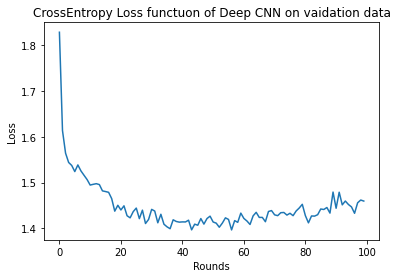

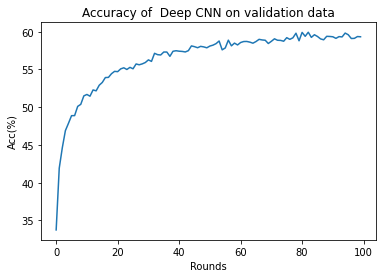

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses3)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs3)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = '/content/drive/My Drive/Fed_Primal_1.pth'
torch.save(Net3.state_dict(), PATH)

In [ ]:
# Model 
Net4 = Deep_CNN(10)
Net4.to(device)

# # Define Loss function and Optimizer
criterion4 = nn.CrossEntropyLoss()

train_losses4 = []
validation_losses4 = []

train_accs4 = []
val_accs4 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.02
w_dict = copy.deepcopy(Net4.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders2[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net4).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net4.load_state_dict(w_dict)
    # print("******", Net3.state_dict()['fc1.bias'])

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader2:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net4(val_data)
            
            val_loss = criterion4(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    train_losses4.append(running_trainloss / train_cnt)
    train_accs4.append(train_acc / train_cnt * 100)
    validation_losses4.append(running_valloss / val_cnt)
    val_accs4.append(val_acc / val_cnt * 100)

  0%|          | 0/30 [00:00<?, ?it/s]

Cost of Train data for client 88 in round 1 for 5 epochs: 1.798319
Cost of Train data for client 69 in round 1 for 5 epochs: 1.646615
Cost of Train data for client 65 in round 1 for 5 epochs: 1.716289
Cost of Train data for client 39 in round 1 for 5 epochs: 1.761473
Cost of Train data for client 71 in round 1 for 5 epochs: 1.813734
Cost of Train data for client 96 in round 1 for 5 epochs: 1.777718
Cost of Train data for client 49 in round 1 for 5 epochs: 1.723426
Cost of Train data for client 60 in round 1 for 5 epochs: 1.708233
Cost of Train data for client 17 in round 1 for 5 epochs: 1.719371
Cost of Train data for client 53 in round 1 for 5 epochs: 1.731750
----------
Cost of Train data for in round 1: 1.739693
Cost of Validation data for in round 1: 1.848531
Acc of Train data for in round 1: 39.752003
Acc of Validation data for in round 1: 33.269997
----------
Cost of Train data for client 34 in round 2 for 5 epochs: 1.240249
Cost of Train data for client 96 in round 2 for 5 epoch

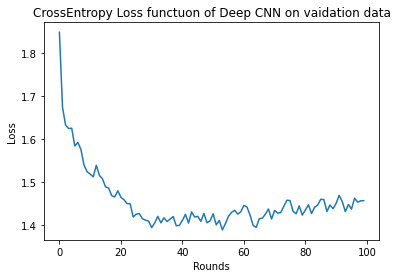

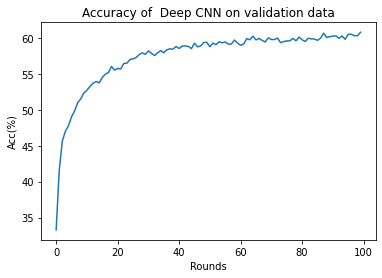

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses4)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs4)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = '/content/drive/My Drive/Fed_Primal_2.pth'
torch.save(Net4.state_dict(), PATH)

# Federated Learning (Non-IID Dataset)

## Split Clients' dataset

In [ ]:
class Cifar10(torch.utils.data.Dataset):
    
    def __init__(self, train_set, list_IDs):
        self.train_set = train_set
        self.list_IDs = list_IDs
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)
    
    def __getitem__(self,index):
        ind = self.list_IDs[index]
        return self.train_set[ind]

In [ ]:
def cifar_noniid(dataset, num_users,  batch_size):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    n = num_users
    n_i = len(dataset) // n // 2 # each class items per client 
    cifar_labels = { i: [] for i in range(10) }

    for i in range(len(dataset)):
        cifar_labels[dataset[i][1]].append(i)

    for i in range(10):
        cifar_labels[i] = [cifar_labels[i][x:x+n_i] for x in range(0, len(cifar_labels[i]), n_i)]
    
    users_dict = dict()
    i = 0
    for user in range(n):
        if len(cifar_labels[i]) > 0:    
            users_dict[user] = cifar_labels[i][0] + cifar_labels[i+1][0]
            del cifar_labels[i][0]
            del cifar_labels[i+1][0]
        
        else :
            i = i + 2
            users_dict[user] = cifar_labels[i][0] + cifar_labels[i+1][0]
            del cifar_labels[i][0]
            del cifar_labels[i+1][0]

    train_loaders = [torch.utils.data.DataLoader(Cifar10(dataset,users_dict[i]), batch_size=batch_size,shuffle=True, num_workers = 2) for i in range(n)] 
    
    return train_loaders

In [ ]:
transform3 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(2045)
n = 100
batch_size3 = 50

trainset3 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform3)

trainloader3 = torch.utils.data.DataLoader(trainset3, batch_size=batch_size3,
                                          shuffle= True, num_workers=2)

testset3 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform3)

testloader3 = torch.utils.data.DataLoader(testset3, batch_size=batch_size3,
                                         shuffle=False, num_workers=2)

train_loaders3 = cifar_noniid(trainset3, n, batch_size3)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
labels = []

for train_data, train_labels in train_loaders3[20]:
    labels.append(train_labels)

In [ ]:
x = 0
for i in labels:
    for j in i:
        if j == 3:
            x += 1

print(x)

250


## FedProx 

In [ ]:
class FedProx_ClientUpdate(object):
    
    def __init__(self, train_loader):

        self.train_loader =  train_loader
        
        # Define Loss function
        self.criterion = nn.CrossEntropyLoss()

    def loss_function(self, net, w_t,batch_train_outputs, train_labels, mu):
        w_dict = net.state_dict()
        loss1 = self.criterion(batch_train_outputs, train_labels)

        loss2 = 0
        for l in w_dict.keys():
            loss2 += torch.norm(w_dict[l].float() - w_t[l].float(), p = 2)
        
        return loss1 + (mu /2) * loss2

    def update(self, net, max_epochs, lr, mu):
        optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)           
        w_t = copy.deepcopy(net.state_dict())

        train_losses = []
        validation_losses = []

        train_accs = []
        val_accs = []

        # Loop over epochs
        for epoch in range(max_epochs):
            
            running_trainloss,  train_acc = 0.0, 0.0
            train_cnt = 0

            # Training
            for train_data, train_labels in self.train_loader:
                # Transfer to GPU
                train_data, train_labels = train_data.to(device), train_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Model computations
                # forward + backward + optimize
                batch_train_outputs = net(train_data)

                loss = self.loss_function(net, w_t, batch_train_outputs, train_labels, mu)
                loss.backward()
                optimizer.step()
                
                # print statistics
                running_trainloss += loss.item()

                train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

                train_cnt += 1
           
            train_losses.append(running_trainloss / train_cnt)
            train_accs.append(train_acc / train_cnt )

        return net.state_dict(), sum(train_losses) / len(train_losses), sum(train_accs)/len(train_accs) 

    def FedAvg(self, w_dict, w_prime_dict, coeff):
        for k in w_dict.keys():
            w_dict[k] = w_dict[k] + coeff * w_prime_dict[k]
        return w_dict

## Non-IID Training

### FedAvg Training

In [ ]:
# Model 
Net6 =  Deep_CNN(10)
Net6.to(device)

# Define Loss function and Optimizer
criterion6 = nn.CrossEntropyLoss()

train_losses6 = []
validation_losses6 = []

train_accs6 = []
val_accs6 = []

max_rounds = 100
C = 0.1
E = 5
learning_rate = 0.01
w_dict = copy.deepcopy(Net6.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedAvg_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net6).to(device), E, learning_rate)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net6.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net6(val_data)
            
            val_loss = criterion6(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    train_losses6.append(running_trainloss / train_cnt)
    train_accs6.append(train_acc / train_cnt * 100)
    validation_losses6.append(running_valloss / val_cnt)
    val_accs6.append(val_acc / val_cnt * 100)

  0%|          | 0/50 [00:00<?, ?it/s]

Cost of Train data for client 37 in round 1 for 5 epochs: 1.352767
Cost of Train data for client 85 in round 1 for 5 epochs: 1.366338
Cost of Train data for client 18 in round 1 for 5 epochs: 1.301941
Cost of Train data for client 20 in round 1 for 5 epochs: 1.334582
Cost of Train data for client 43 in round 1 for 5 epochs: 1.464218
Cost of Train data for client 31 in round 1 for 5 epochs: 1.354798
Cost of Train data for client 61 in round 1 for 5 epochs: 1.269915
Cost of Train data for client 78 in round 1 for 5 epochs: 1.284345
Cost of Train data for client 83 in round 1 for 5 epochs: 1.339795
Cost of Train data for client 84 in round 1 for 5 epochs: 1.343991
----------
Cost of Train data for in round 1: 1.341269
Cost of Validation data for in round 1: 2.328208
Acc of Train data for in round 1: 47.560001
Acc of Validation data for in round 1: 10.000006
----------
Cost of Train data for client 61 in round 2 for 5 epochs: 1.001275
Cost of Train data for client 25 in round 2 for 5 epoch

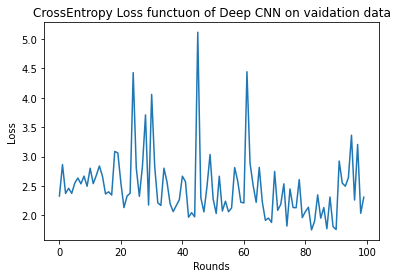

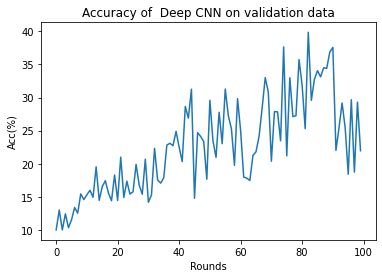

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses6)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs6)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = '/content/drive/My Drive/Fed_Non_IID_1.pth'
torch.save(Net6.state_dict(), PATH)

### FedProx Training

In [ ]:
# Model 
Net5 =  Deep_CNN(10)
Net5.to(device)

# Define Loss function and Optimizer
criterion5 = nn.CrossEntropyLoss()

train_losses5 = []
validation_losses5 = []

train_accs5 = []
val_accs5 = []

max_rounds = 50
C = 0.1
E = 5
mu = 3
learning_rate = 0.01
w_dict = copy.deepcopy(Net5.state_dict())

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedProx_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net5).to(device), E, learning_rate, mu)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net5.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net5(val_data)
            
            val_loss = criterion5(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    train_losses5.append(running_trainloss / train_cnt)
    train_accs5.append(train_acc / train_cnt * 100)
    validation_losses5.append(running_valloss / val_cnt)
    val_accs5.append(val_acc / val_cnt * 100)

  0%|          | 0/50 [00:00<?, ?it/s]

Cost of Train data for client 66 in round 1 for 5 epochs: 5.874538
Cost of Train data for client 60 in round 1 for 5 epochs: 5.167677
Cost of Train data for client 65 in round 1 for 5 epochs: 5.971993
Cost of Train data for client 7 in round 1 for 5 epochs: 5.864898
Cost of Train data for client 96 in round 1 for 5 epochs: 5.944652
Cost of Train data for client 46 in round 1 for 5 epochs: 5.162351
Cost of Train data for client 3 in round 1 for 5 epochs: 5.871751
Cost of Train data for client 73 in round 1 for 5 epochs: 5.835662
Cost of Train data for client 6 in round 1 for 5 epochs: 5.860949
Cost of Train data for client 35 in round 1 for 5 epochs: 5.173067
----------
Cost of Train data for in round 1: 5.672754
Cost of Validation data for in round 1: 2.493352
Acc of Train data for in round 1: 46.135998
Acc of Validation data for in round 1: 12.440009
----------
Cost of Train data for client 95 in round 2 for 5 epochs: 6.601043
Cost of Train data for client 64 in round 2 for 5 epochs: 

In [ ]:

# Loop over epochs
for round in tqdm(range(max_rounds)):
    running_trainloss, running_valloss, train_acc = 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0
    clients = random.sample(list(np.arange(n)), k = int(C * n))
    coeffs = [ 1 / len(clients) for i in range(n)]

    for k in w_dict.keys():
        w_dict[k] = torch.zeros_like(w_dict[k])
    
    # Training
    for i in clients:
        cl_upd = FedProx_ClientUpdate(train_loaders3[i])
        w_prime_dict, train_loss, acc = cl_upd.update(copy.deepcopy(Net5).to(device), E, learning_rate, mu)
        w_dict = cl_upd.FedAvg(w_dict, w_prime_dict, coeffs[i])
        print("Cost of Train data for client %i in round %i for %i epochs: %f" %(i+1, round + 1, E, train_loss))      
        running_trainloss += train_loss
        train_acc += acc
        train_cnt += 1

    Net5.load_state_dict(w_dict)

    val_acc = 0
    with torch.set_grad_enabled(False):
        for val_data, val_labels in testloader3:
            # Transfer to GPU
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            batch_outputs = Net5(val_data)
            
            val_loss = criterion5(batch_outputs, val_labels.long())

            running_valloss += val_loss.item()

            val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

            val_cnt += 1

    # learning_rate = learning_rate * 0.99        
    print("-"*10)
    print("Cost of Train data for in round %i: %f" %(round + 1, running_trainloss / train_cnt))
    print("Cost of Validation data for in round %i: %f" %(round + 1, running_valloss / val_cnt))
    print("Acc of Train data for in round %i: %f" %(round + 1, train_acc / train_cnt * 100)) 
    print("Acc of Validation data for in round %i: %f" %(round + 1, val_acc / val_cnt * 100))  
    print("-"*10)
    train_losses5.append(running_trainloss / train_cnt)
    train_accs5.append(train_acc / train_cnt * 100)
    validation_losses5.append(running_valloss / val_cnt)
    val_accs5.append(val_acc / val_cnt * 100)

  0%|          | 0/50 [00:00<?, ?it/s]

Cost of Train data for client 24 in round 1 for 5 epochs: 6.825887
Cost of Train data for client 59 in round 1 for 5 epochs: 3.373535
Cost of Train data for client 6 in round 1 for 5 epochs: 7.588527
Cost of Train data for client 55 in round 1 for 5 epochs: 3.419562
Cost of Train data for client 92 in round 1 for 5 epochs: 8.013358
Cost of Train data for client 66 in round 1 for 5 epochs: 7.434461
Cost of Train data for client 19 in round 1 for 5 epochs: 7.451779
Cost of Train data for client 61 in round 1 for 5 epochs: 7.668989
Cost of Train data for client 14 in round 1 for 5 epochs: 7.601761
Cost of Train data for client 1 in round 1 for 5 epochs: 7.652651
----------
Cost of Train data for in round 1: 6.703051
Cost of Validation data for in round 1: 2.481690
Acc of Train data for in round 1: 80.356010
Acc of Validation data for in round 1: 19.470005
----------
Cost of Train data for client 17 in round 2 for 5 epochs: 2.776118
Cost of Train data for client 53 in round 2 for 5 epochs:

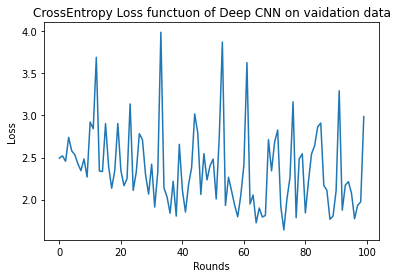

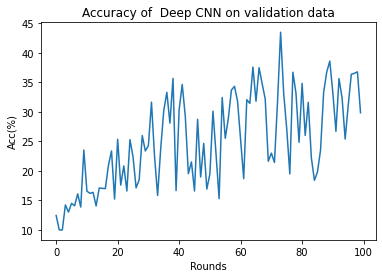

In [ ]:
plot_cost, plot_acc = 1, 1
# plot the cost
if plot_cost:
    # plt.plot(train_losses3)
    plt.plot(validation_losses5)
    plt.title("CrossEntropy Loss functuon of Deep CNN on vaidation data")
    plt.ylabel('Loss')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

if plot_acc:
    # plt.plot(train_accs3)
    plt.plot(val_accs5)
    plt.title("Accuracy of  Deep CNN on validation data")
    plt.ylabel('Acc(%)')
    plt.xlabel('Rounds')
    # plt.legend(labels = ["Train","Validation"])
    plt.show()

In [ ]:
PATH = '/content/drive/My Drive/Fed_Non_IID_2.pth'
torch.save(Net5.state_dict(), PATH)